<a href="https://colab.research.google.com/github/Ariq154404/IM-Project-2/blob/main/Jigsaw_FeatureEngg_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The part is done in google collab to generate cls token from Bert model**

In [ ]:
!pip install transformers


     |████████████████████████████████| 2.5MB 34.2MB/s 
     |████████████████████████████████| 3.3MB 48.2MB/s 
     |████████████████████████████████| 901kB 43.4MB/s 


# Import 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).to('cuda')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Drive mounted to upload requred files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Tokenized values are taken from the saved values in google collab

In [ ]:

from numpy import load
# load array
tokenized = load('/content/drive/MyDrive/Colab Notebooks/tokenized.npy',allow_pickle=True)

In [ ]:
tokenized.shape

(187320,)

Maximum length are figured out to be used in padding

In [ ]:
max_len = 0
for i in tokenized:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])

Padded array is being formed to homogenize length

```
# This is formatted as code
```



In [ ]:
np.array(padded).shape

(187320, 415)

attention mask are being declared to represent the importance of the values in the padded sequence and to ignore the 0s

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(187320, 415)

Total feature is being declares to coucht the total number of features

In [ ]:
tot_feature=np.array([])

Padded and Attention mask are being turned into batched to fit the size of output feature as the attention and the padded sequence chunck are being recreated for each iteration

In [ ]:
batch_padded=np.split(padded,187320//10)

In [ ]:
batch_attention_mask=np.split(attention_mask,187320//10)

Pytorch is being referend to GPU

In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tensors are being processed to output cls token feature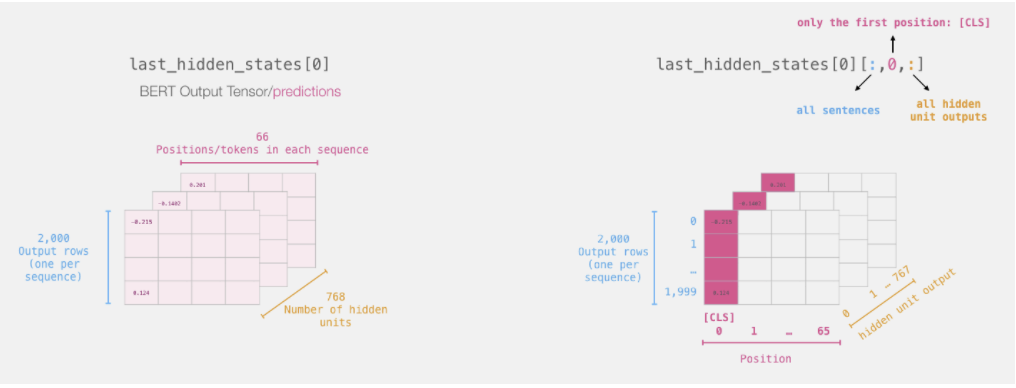

In [ ]:
for i in range(len(batch_padded)):
    input_ids = torch.tensor(batch_padded[i]).to(device)
    attention_mask = torch.tensor(batch_attention_mask[i]).to(device)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    if i==0:
        tot_feature=last_hidden_states[0][:,0,:].cpu().numpy()
    else:
        tot_feature=np.concatenate((tot_feature,last_hidden_states[0][:,0,:].cpu().numpy()),axis=0)

In [ ]:
tot_feature.shape

(187320, 768)

Total feature is being saved for finetuning

In [ ]:
from numpy import save
save('/content/drive/MyDrive/Colab Notebooks/tot_feature.npy', tot_feature)

In [ ]:
tot_feature[:2]

array([[ 0.13391662, -0.03294995,  0.07548678, ...,  0.01651316,
         0.3127196 ,  0.3308168 ],
       [ 0.06461061,  0.04353015, -0.11498661, ...,  0.18790026,
         0.4419425 ,  0.40909052]], dtype=float32)